### This is a Dev notebook for Spaceship titanic dataset.

### Outline:
0. Load libraries and custom functions.
1. Load data.
2. Preliminary data analysis: explore features and a target, delete unneeded features, create new features.
3. Train-test split.
4. Missing values. In some cases it may be useful to explore skew and perform log-transform before imputing missing values.
5. Feature engineering. Transform skewed variables, do OHC and scaling.
6. Fit models.
7. Evaluate models.
8. Feature importance, error analysis. Based on the results, go to 2. and iterate.

Other notes:
- Adding more features seems to hurt results.
- I tried adding features based on group, room, dummies for missinf values - none helped.


In [1]:
# 0. Load libraries #

import numpy as np
import pandas as pd
import os, time, warnings, optuna, shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 40)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')

# Load custom pre-processing functions:

def fillna_mp_i1(df_train, df_test, df_pred, num_features, cat_features, num_fill='median', cat_fill='mode'):
    """
    This function speeds up filling missing values for 3 main datasets using different imputation methods.
    Later may replace it with some subclass.
    Example: fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)
    """
    # set df_pred to None if it does not exist
    if not ((cat_fill=='mode') and (num_fill=='median')):
        print ('Imputation method not Implemented yet!')
        return None
    
    df_train[num_features] = df_train[num_features].fillna(value=df_train[num_features].median())
    df_test[num_features] = df_test[num_features].fillna(value=df_train[num_features].median())
    df_train[cat_features] = df_train[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_test[cat_features] = df_test[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    if (df_pred is not None):
        df_pred[num_features] = df_pred[num_features].fillna(value=df_train[num_features].median())
        df_pred[cat_features] = df_pred[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_train[num_features+cat_features].count
    
    all_good = (
    (np.prod(df_train[num_features+cat_features].shape)==df_train[num_features+cat_features].count().sum()) and 
    (np.prod(df_test[num_features+cat_features].shape) == df_test[num_features+cat_features].count().sum()) and 
    (np.prod(df_pred[num_features+cat_features].shape) == df_pred[num_features+cat_features].count().sum()))
    if (all_good):
        print('Missing values imputed successfully')
    else:
        print('There are still some missing values...')
    
def add_misDummy_mp_i1(df_train, df_test, df_pred, features):
    """
    This function creates new dummy columns for missing features.
    Example: add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age'])
    """
    # set df_pred to None if it does not exist
    for feature_name in features:
        misColName = 'mis'+feature_name
        df_train.loc[df_train[feature_name].isnull(), misColName]=1
        df_train.loc[df_train[feature_name].notnull(), misColName]=0
        df_test.loc[df_test[feature_name].isnull(), misColName]=1
        df_test.loc[df_test[feature_name].notnull(), misColName]=0
        if (df_pred is not None):
            df_pred.loc[df_pred[feature_name].isnull(), misColName]=1
            df_pred.loc[df_pred[feature_name].notnull(), misColName]=0
   

    
def add_dummyfeatures(df_train, df_test, df_pred, feature_dict):
    """
    This function adds dummy feature when some feature is equal to value, specified in a dictionary.
    Example: add_dummyfeatures(X_train, X_test, X_pred, {'RoomService':0, 'Spa':0, 'VRDeck':0, 'ShoppingMall':0})
    """
    input_dimensions = np.array([df_train.shape[1], df_test.shape[1], df_pred.shape[1]])
    for i in range(len(list(feature_dict.items()))):
        feature,value = list(feature_dict.keys())[i], list(feature_dict.values())[i]
        df_train.loc[df_train[feature]==value,(str(feature)+str(value))]=1
        df_train.loc[df_train[feature]!=value,(str(feature)+str(value))]=0
        df_test.loc[df_test[feature]==value,(str(feature)+str(value))]=1
        df_test.loc[df_test[feature]!=value,(str(feature)+str(value))]=0
        df_pred.loc[df_pred[feature]==value,(str(feature)+str(value))]=1
        df_pred.loc[df_pred[feature]!=value,(str(feature)+str(value))]=0
    output_dimensions = np.array([df_train.shape[1], df_test.shape[1], df_pred.shape[1]])
    print(output_dimensions-input_dimensions, ' variables created') 
    
    
# 1. Load data #

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('/home/jupyter/projects_data')

In [3]:
time0 = time.time()

path = 'space_titanic/train.csv'
df = pd.read_csv(path) 
df0 = df.copy()

pred=pd.read_csv('space_titanic/test.csv')
pred0 = pred.copy()

print(df.shape, pred.shape)
df.head()

(8693, 14) (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# 2. pEDA #
df[['Deck', 'Room', 'Side']] = df['Cabin'].str.split('/', 2, expand=True)
df[['Group_Id', 'Passeng_Id']] = df['PassengerId'].str.split('_', 1, expand=True)
pred[['Deck', 'Room', 'Side']] = pred['Cabin'].str.split('/', 2, expand=True)
pred[['Group_Id', 'Passeng_Id']] = pred['PassengerId'].str.split('_', 1, expand=True)
df.drop(columns = ['PassengerId', 'Cabin', 'Name', 'Passeng_Id'], inplace = True)
pred.drop(columns = ['PassengerId', 'Cabin', 'Name', 'Passeng_Id'], inplace = True)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Room,Side,Group_Id
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,0001
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,0002
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,0003
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,0003
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,0004


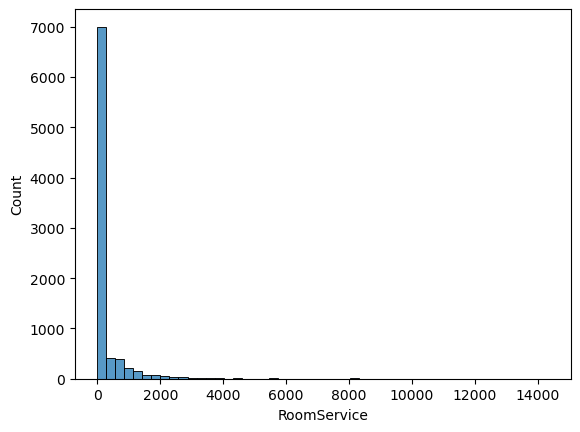

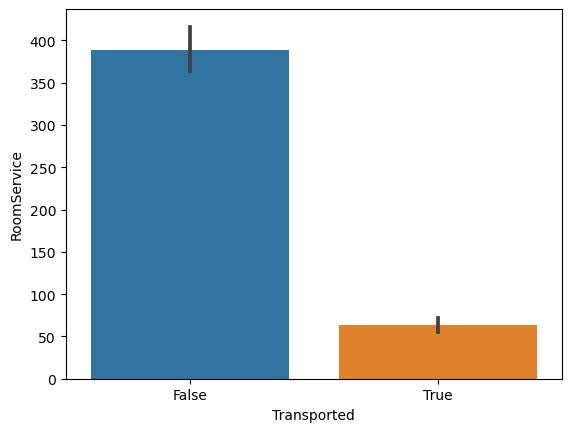

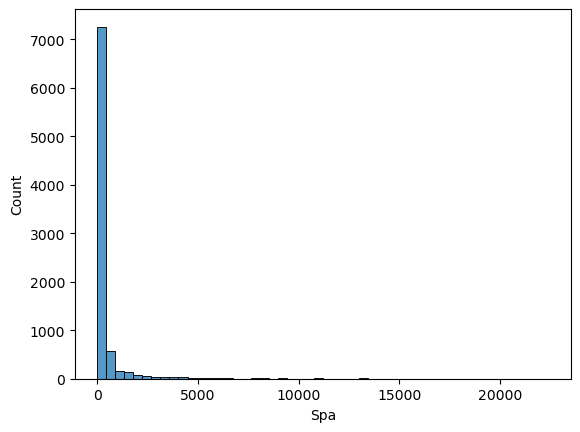

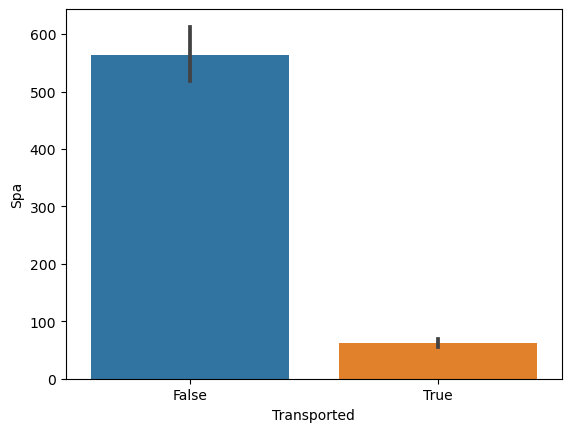

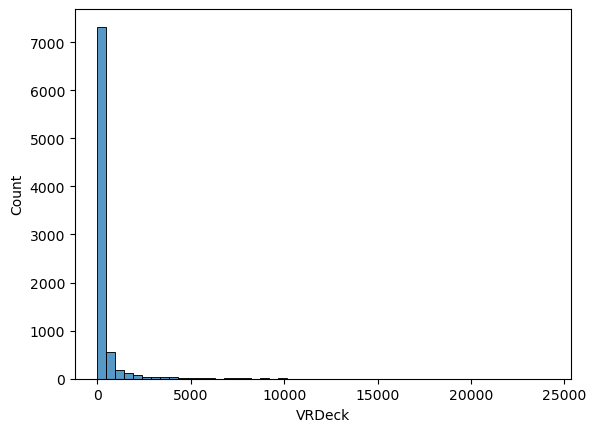

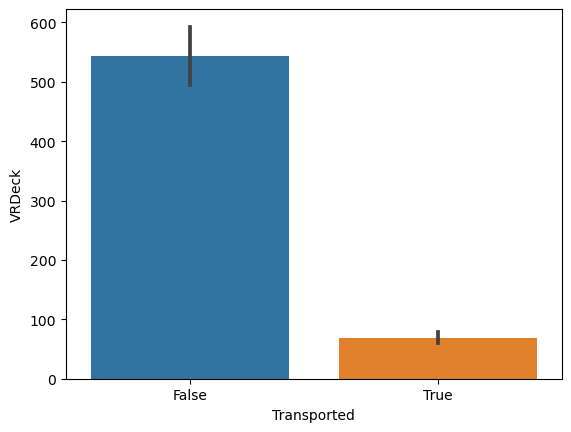

In [5]:
sns.histplot(x='RoomService', data=df, bins=50)
plt.show()
sns.barplot(x='Transported', y='RoomService', data=df)
plt.show()
sns.histplot(x='Spa', data=df, bins=50)
plt.show()
sns.barplot(x='Transported', y='Spa', data=df)
plt.show()
sns.histplot(x='VRDeck', data=df, bins=50)
plt.show()
sns.barplot(x='Transported', y='VRDeck', data=df)
plt.show()
# sns.barplot(x='Transported', y='CryoSleep', data=df)
# plt.show()

In [6]:
# 3. Train-test split #

train_y = df[['Transported']]
train_x = df.drop(columns = ['Transported'])
X_pred = pred.copy()

cat_cols = [col for col in train_x.columns if train_x[col].nunique() in range(2,10)]
num_cols = list(set(train_x.columns)-set(cat_cols)-{'Group_Id', 'Room'})

print('categorical features: ', cat_cols, 'numerical features: ', num_cols)

X_train, X_test, y_train, y_test = train_test_split(train_x, 
                                                    train_y, 
                                                    test_size = 0.1, 
                                                    random_state=33)
print(X_train.shape, X_test.shape, y_train.shape, X_pred.shape)

X_train.info()

# add room and group variables:

roomsize = X_train.groupby('Room').size().to_frame()
roomsize.reset_index(inplace=True)
roomsize.columns = ['Room', 'Num_ppl_room']
roomsize.sort_values('Num_ppl_room', inplace = True)
X_train = pd.merge(X_train, roomsize, on='Room', how='left')
X_test = pd.merge(X_test, roomsize, on='Room', how='left')
X_pred = pd.merge(X_pred, roomsize, on='Room', how='left')
groupsize = X_train.groupby('Group_Id').size().to_frame()
groupsize.reset_index(inplace=True)
groupsize.columns = ['Group_Id', 'Num_ppl_group']
groupsize.sort_values('Num_ppl_group', inplace = True)
X_train = pd.merge(X_train, groupsize, on='Group_Id', how='left')
X_test = pd.merge(X_test, groupsize, on='Group_Id', how='left')
X_pred = pd.merge(X_pred, groupsize, on='Group_Id', how='left')

num_cols.extend(['Num_ppl_room', 'Num_ppl_group'])


# 4. Missing values #

#add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'RoomService',
#'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Side'])
fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)
X_train.info()

# 5. Feature engineering #

# add useful variables:
# add_dummyfeatures(X_train, X_test, X_pred, 
#                   {'RoomService':0, 'Spa':0, 'VRDeck':0, 'ShoppingMall':0})
# ZeroFC dummy seems to hurt results...

# add more features 

X_train.drop(columns=['Room', 'Group_Id'], inplace= True)
X_train.loc[(X_train['RoomService']==0)&
            (X_train['FoodCourt']==0)&
            (X_train['ShoppingMall']==0)&
            (X_train['Spa']==0)&
            (X_train['VRDeck']==0),'ZeroService'] = 1
X_train.loc[X_train.ZeroService.isnull(), 'ZeroService'] = 0

X_test.drop(columns=['Room', 'Group_Id'], inplace= True)
X_test.loc[(X_test['RoomService']==0)&
           (X_test['FoodCourt']==0)&
           (X_test['ShoppingMall']==0)&
           (X_test['Spa']==0)&
           (X_test['VRDeck']==0),'ZeroService'] = 1
X_test.loc[X_test.ZeroService.isnull(), 'ZeroService'] = 0

X_pred.drop(columns=['Room', 'Group_Id'], inplace= True)
X_pred.loc[(X_pred['RoomService']==0)&
           (X_pred['FoodCourt']==0)&
           (X_pred['ShoppingMall']==0)&
           (X_pred['Spa']==0)&
           (X_pred['VRDeck']==0),'ZeroService'] = 1
X_pred.loc[X_pred.ZeroService.isnull(), 'ZeroService'] = 0

# cat_cols.extend(['RoomService0', 'Spa0', 'VRDeck0', 'ShoppingMall0', 'ZeroService'])
cat_cols.extend(['ZeroService'])


X_train.describe()
X_train[:5]

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), cat_cols),
    ], remainder = "passthrough")

X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_pred = pd.DataFrame(feature_transformer.transform(X_pred), columns=feature_transformer.get_feature_names_out())

print(X_train.shape)
display(X_train.head())

categorical features:  ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'] numerical features:  ['Spa', 'VRDeck', 'ShoppingMall', 'Age', 'RoomService', 'FoodCourt']
(7823, 14) (870, 14) (7823, 1) (4277, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7823 entries, 5533 to 7188
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    7640 non-null   object 
 1   CryoSleep     7624 non-null   object 
 2   Destination   7670 non-null   object 
 3   Age           7660 non-null   float64
 4   VIP           7645 non-null   object 
 5   RoomService   7660 non-null   float64
 6   FoodCourt     7653 non-null   float64
 7   ShoppingMall  7637 non-null   float64
 8   Spa           7656 non-null   float64
 9   VRDeck        7659 non-null   float64
 10  Deck          7648 non-null   object 
 11  Room          7648 non-null   object 
 12  Side          7648 non-null   object 
 13  Group_Id      7823 

,cat__HomePlanet_Earth,cat__HomePlanet_Europa,cat__HomePlanet_Mars,cat__CryoSleep_True,cat__Destination_55 Cancri e,cat__Destination_PSO J318.5-22,cat__Destination_TRAPPIST-1e,cat__VIP_True,cat__Deck_A,cat__Deck_B,cat__Deck_C,cat__Deck_D,cat__Deck_E,cat__Deck_F,cat__Deck_G,cat__Deck_T,cat__Side_S,cat__ZeroService_1.0,remainder__Age,remainder__RoomService,remainder__FoodCourt,remainder__ShoppingMall,remainder__Spa,remainder__VRDeck,remainder__Num_ppl_room,remainder__Num_ppl_group
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,62.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,22.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25.0,122.0,84.0,0.0,0.0,0.0,11.0,5.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61.0,0.0,53.0,813.0,3.0,0.0,1.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,74.0,0.0,193.0,581.0,0.0,0.0,4.0,1.0


In [12]:
np.array(X_train.iloc[0,:])

array([ 0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1., 62.,  0.,  0.,  0.,  0.,  0.,  3.,  3.])

In [7]:
# 6. Fit xgb #

time1 = time.time()
xgb = XGBClassifier(tree_method='gpu_hist', 
                    n_jobs=-1,
                    n_estimators=200,
                    max_depth=5,
                    eta=0.1,
                    subsample=0.8,
                    colsample_bytree=0.6
)

xgb.fit(X_train, y_train)
print('XGB ', 
      accuracy_score(y_train, xgb.predict(X_train)), 
      time.time()-time1)

print('Out of Sample:')
print('XGB ', accuracy_score(y_test, xgb.predict(X_test)))
print('Total time ', time.time()-time0)

XGB  0.8618177169883676 0.9021925926208496
Out of Sample:
XGB  0.7919540229885057
Total time  2.4687345027923584


In [8]:
time1 = time.time()
xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0, min_child_weight=5)
# use 'gpu_hist' for more than 10,000 examples.
param_grid = {'n_estimators': [200], 
              'max_depth': [4, 5], 
              'eta': [0.03, 0.04, 0.05, 0.06], 
              'subsample': [0.6],
              'colsample_bytree': [0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2)
xgbm.fit(X_train, y_train)
print('XGB ', 
      xgbm.best_params_, 
      xgbm.best_score_, 
      accuracy_score(y_train, xgbm.predict(X_train)), 
      time.time()-time1)

print('Out of Sample:')
print('XGB ', accuracy_score(y_test, xgbm.predict(X_test)))
print('Total time ', time.time()-time0)

XGB  {'colsample_bytree': 0.6, 'eta': 0.06, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.6} 0.8000758439700515 0.8251310239038732 4.014117479324341
Out of Sample:
XGB  0.803448275862069
Total time  6.495868682861328


In [9]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

    cv_regularizer=0.08
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 1,  
        "n_estimators": trial.suggest_int("n_estimators", 400, 800),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.2),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 20.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 200.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] = model.predict(X_B).reshape(-1,1)
            y_pred_train[train_index] = model.predict(X_A).reshape(-1,1)
            
        score_train = accuracy_score(y_train, y_pred_train)
        score_test = accuracy_score(y_train, y_pred) 
        overfit = score_train-score_test
        temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

[I 2022-10-26 18:35:24,939] A new study created in memory with name: no-name-55e620ce-2a95-4b60-884f-e75a3b9d4545
[I 2022-10-26 18:35:26,178] Trial 0 finished with value: 0.7910312539946311 and parameters: {'n_estimators': 541, 'max_depth': 3, 'learning_rate': 0.14014605204448172, 'colsample_bytree': 0.6005091352556653, 'subsample': 0.5951535076603844, 'alpha': 1.6299596400537715, 'lambda': 2.963358680990785, 'gamma': 0.01792986984537007, 'min_child_weight': 0.2520362050754417}. Best is trial 0 with value: 0.7910312539946311.
[I 2022-10-26 18:35:28,985] Trial 1 finished with value: 0.7888070433337594 and parameters: {'n_estimators': 558, 'max_depth': 6, 'learning_rate': 0.10256929291085984, 'colsample_bytree': 0.5135544843771361, 'subsample': 0.7262266404653308, 'alpha': 2.1810029774045, 'lambda': 0.4683081727548084, 'gamma': 0.00010146277630847409, 'min_child_weight': 0.4842493074385342}. Best is trial 0 with value: 0.7910312539946311.
[I 2022-10-26 18:35:30,866] Trial 2 finished with

Total time for hypermarameter optimization  53.17473220825195
        n_estimators : 729
           max_depth : 5
       learning_rate : 0.17625701191583926
    colsample_bytree : 0.44984435066571027
           subsample : 0.5226732488963329
               alpha : 7.232540274645385
              lambda : 179.83217209870904
               gamma : 1.567430529120381e-06
    min_child_weight : 2.8020303281901
best objective value : 0.8020452511824109


In [10]:
optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_xgb = XGBClassifier(**optuna_hyperpars, seed=8)
optuna_xgb.fit(X_train, y_train)
print('XGB train', 
      accuracy_score(y_train, optuna_xgb.predict(X_train)), 
      time.time()-time1)

print('Out of Sample:')
print('XGB ', accuracy_score(y_test, optuna_xgb.predict(X_test)))
print('Total time ', time.time()-time0)

XGB train 0.8293493544675955 54.119842767715454
Out of Sample:
XGB  0.7942528735632184
Total time  60.64047932624817


In [11]:
# 8. feature importance #

results = permutation_importance(optuna_xgb, X_test, y_test, scoring='accuracy', n_jobs=-1)
fi_lr = pd.DataFrame({'col':X_test.columns, 'FI':results.importances_mean})
fi_lr.sort_values('FI', ascending = False)

,col,FI
22,remainder__Spa,0.035402
20,remainder__FoodCourt,0.025057
23,remainder__VRDeck,0.021379
3,cat__CryoSleep_True,0.016782
19,remainder__RoomService,0.015172
17,cat__ZeroService_1.0,0.013103
21,remainder__ShoppingMall,0.006897
0,cat__HomePlanet_Earth,0.006667
14,cat__Deck_G,0.006437
6,cat__Destination_TRAPPIST-1e,0.005747


,col_name,feature_importance_vals
22,remainder__Spa,0.481154
3,cat__CryoSleep_True,0.453980
23,remainder__VRDeck,0.416324
17,cat__ZeroService_1.0,0.411437
20,remainder__FoodCourt,0.348615
19,remainder__RoomService,0.324020
14,cat__Deck_G,0.310943
16,cat__Side_S,0.282993
0,cat__HomePlanet_Earth,0.193192
1,cat__HomePlanet_Europa,0.186769


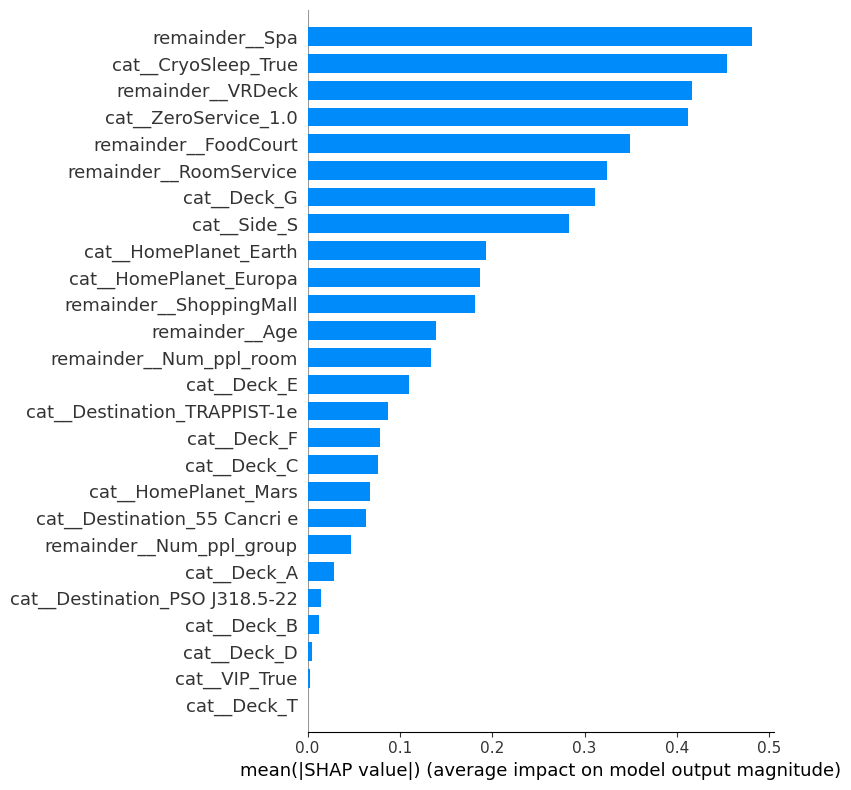

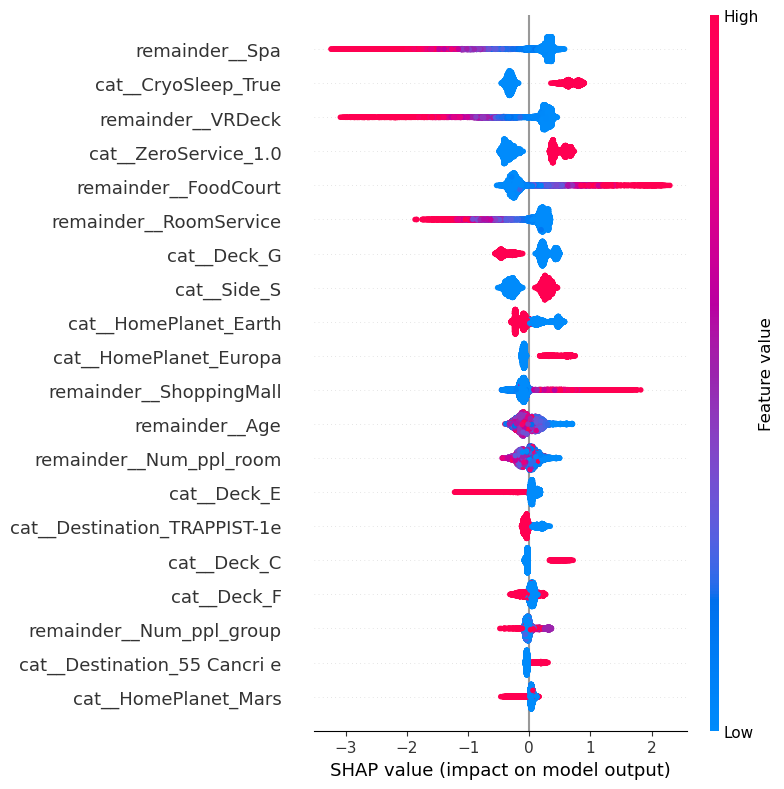

In [12]:
# SHAP feature importances

explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, 
                               inplace=True)
display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)
shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)